In [1]:
import sys
import os
import re
import glob
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sys.path.insert(0, "../")

from mdu.eval.table_analysis_utils import (
    transform_by_tasks,
    select_composite_and_components,
    check_composite_dominance,
    compute_average_ranks,
    analyze_composite_pareto_performance,
)
from configs.interesting_compositions import INTERESTING_COMPOSITIONS

# Set pandas display options to show all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)


In [2]:
def parse_hyperparameters_from_filename(filename: str) -> Dict[str, Union[str, float]]:
    """
    Parse hyperparameters from CSV filename.
    
    Args:
        filename: CSV filename like 'per_comp_scaled_benchmark_entropic_target_exp_eps_2.0_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_1_global_scaler.csv'
    
    Returns:
        Dictionary with parsed hyperparameters
    """
    hyperparams = {}
    
    # Extract eps (epsilon)
    eps_match = re.search(r'eps_([0-9.]+)', filename)
    if eps_match:
        hyperparams['eps'] = float(eps_match.group(1))
    
    # Extract iterations
    iters_match = re.search(r'iters_(\d+)', filename)
    if iters_match:
        hyperparams['iters'] = int(iters_match.group(1))
    
    # Extract tolerance
    tol_match = re.search(r'tol_([0-9e.-]+)', filename)
    if tol_match:
        hyperparams['tol'] = float(tol_match.group(1))
    
    # Extract random seed
    rs_match = re.search(r'rs_(\d+)', filename)
    if rs_match:
        hyperparams['rs'] = int(rs_match.group(1))
    
    # Extract grid size
    grid_match = re.search(r'grid_size_(\d+)', filename)
    if grid_match:
        hyperparams['grid_size'] = int(grid_match.group(1))
    
    # Extract n_targets_multiplier
    targets_match = re.search(r'n_targets_multiplier_(\d+)', filename)
    if targets_match:
        hyperparams['n_targets_multiplier'] = int(targets_match.group(1))
    
    # Check for global_scaler
    if 'global_scaler' in filename:
        hyperparams['scaler_type'] = 'global_scaler'
    elif 'mahalanobis' in filename:
        hyperparams['scaler_type'] = 'mahalanobis'
    else:
        hyperparams['scaler_type'] = 'none'
    
    # Extract base experiment type
    if 'per_comp_scaled_benchmark' in filename:
        hyperparams['experiment_type'] = 'per_comp_scaled_benchmark'
    elif 'benchmark' in filename:
        hyperparams['experiment_type'] = 'benchmark'
    else:
        hyperparams['experiment_type'] = 'other'
    
    return hyperparams


def load_and_combine_csv_files(pattern: str = "per_comp_scaled_benchmark*.csv", 
                              base_dir: str = "../") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load multiple CSV files matching the pattern and combine them with hyperparameter metadata.
    
    Args:
        pattern: Glob pattern to match CSV files
        base_dir: Base directory to search for files
    
    Returns:
        Tuple of (combined_df, loading_summary_df)
    """
    csv_files = glob.glob(os.path.join(base_dir, pattern))
    
    if not csv_files:
        raise FileNotFoundError(f"No files found matching pattern: {pattern}")
    
    combined_data = []
    loading_info = []
    
    for csv_file in csv_files:
        # Load the CSV
        df = pd.read_csv(csv_file)
        
        # Parse hyperparameters from filename
        filename = os.path.basename(csv_file)
        hyperparams = parse_hyperparameters_from_filename(filename)
        
        # Add hyperparameter columns
        for param, value in hyperparams.items():
            df[param] = value
        
        # Add source filename for reference
        df['source_file'] = filename
        
        combined_data.append(df)
        
        # Track loading info
        loading_info.append({
            'filename': filename,
            'rows': len(df),
            **hyperparams
        })
    
    # Combine all DataFrames
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # Create summary DataFrame
    loading_summary = pd.DataFrame(loading_info)
    
    return combined_df, loading_summary


In [3]:
def analyze_hyperparameter_effects_general(
    combined_df: pd.DataFrame, 
    composite_names: Optional[List[str]] = None,
    selective_metric: str = "acc_cov_auc"
) -> Tuple[Dict[str, pd.DataFrame], pd.DataFrame]:
    """
    Analyze how hyperparameter changes affect composite uncertainty measures across all datasets.
    
    Args:
        combined_df: Combined DataFrame with hyperparameter metadata
        composite_names: List of composite names to analyze (if None, uses all from INTERESTING_COMPOSITIONS)
        selective_metric: Metric to use for selective prediction
    
    Returns:
        Tuple of (results_dict, analysis_summary_df)
    """
    if composite_names is None:
        composite_names = list(INTERESTING_COMPOSITIONS.keys())
    
    results = {}
    analysis_info = []
    
    # Get unique hyperparameter combinations
    hyperparam_cols = [col for col in combined_df.columns 
                      if col in ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type']]
    
    # Group by hyperparameter combinations
    grouped = combined_df.groupby(hyperparam_cols)
    
    # Track analysis info
    for name, group in grouped:
        if isinstance(name, tuple):
            param_str = ", ".join([f"{col}={val}" for col, val in zip(hyperparam_cols, name)])
            param_dict = dict(zip(hyperparam_cols, name))
        else:
            param_str = f"{hyperparam_cols[0]}={name}"
            param_dict = {hyperparam_cols[0]: name}
        
        analysis_info.append({
            'hyperparameter_combination': param_str,
            'rows_count': len(group),
            **param_dict
        })
    
    # Analyze each composite measure
    for composite_name in composite_names:
        composite_results = []
        
        for param_combination, group_df in grouped:
            try:
                # Transform the data for this hyperparameter combination
                transformed_df = transform_by_tasks(group_df, selective_metric=selective_metric)
                
                # Get composite and components
                composite_df = select_composite_and_components(transformed_df, composite_name)
                
                # Check dominance
                dominance_df = check_composite_dominance(composite_df)
                
                # Compute average ranks
                avg_ranks = compute_average_ranks(transformed_df)
                
                # Pareto analysis
                pareto_results = analyze_composite_pareto_performance(
                    transformed_df, {composite_name: INTERESTING_COMPOSITIONS[composite_name]}
                )
                
                # Create summary for this parameter combination
                if isinstance(param_combination, tuple):
                    param_dict = dict(zip(hyperparam_cols, param_combination))
                else:
                    param_dict = {hyperparam_cols[0]: param_combination}
                
                summary = {
                    **param_dict,
                    'n_problems': len(dominance_df),
                    'dominates_100_pct': dominance_df['if_dominates_100%'].sum(),
                    'dominates_75_pct': dominance_df['if_dominates_75%'].sum(),
                    'dominates_50_pct': dominance_df['if_dominates_50%'].sum(),
                    'beats_worst_component': dominance_df['beats_worst_component'].sum(),
                }
                
                # Add composite rank if available
                composite_key = composite_name.lower()
                if composite_key in avg_ranks:
                    summary['avg_rank'] = avg_ranks[composite_key]
                
                # Add pareto performance
                if composite_name in pareto_results:
                    pareto_data = pareto_results[composite_name]
                    summary['pareto_count'] = pareto_data['pareto_count']
                    summary['pareto_total'] = pareto_data['total_problems']
                    summary['pareto_percentage'] = pareto_data['pareto_percentage']
                
                composite_results.append(summary)
                
            except Exception as e:
                continue
        
        if composite_results:
            results[composite_name] = pd.DataFrame(composite_results)
    
    analysis_summary = pd.DataFrame(analysis_info)
    
    return results, analysis_summary


def compare_hyperparameters_by_metric(
    analysis_results: Dict[str, pd.DataFrame],
    metric: str = 'pareto_percentage'
) -> pd.DataFrame:
    """
    Compare hyperparameter effects across different composite measures for a specific metric.
    
    Args:
        analysis_results: Results from analyze_hyperparameter_effects_general
        metric: Metric to compare ('pareto_percentage', 'avg_rank', 'dominates_50_pct', etc.)
    
    Returns:
        DataFrame with hyperparameter combinations as rows and composite measures as columns
    """
    comparison_data = []
    
    for composite_name, results_df in analysis_results.items():
        if metric not in results_df.columns:
            print(f"Metric '{metric}' not found in results for {composite_name}")
            continue
        
        # Get hyperparameter columns (exclude metric columns)
        hyperparam_cols = [col for col in results_df.columns 
                          if col not in ['n_problems', 'dominates_100_pct', 'dominates_75_pct', 
                                        'dominates_50_pct', 'beats_worst_component', 'avg_rank',
                                        'pareto_count', 'pareto_total', 'pareto_percentage']]
        
        for _, row in results_df.iterrows():
            param_combo = tuple(row[col] for col in hyperparam_cols)
            comparison_data.append({
                'hyperparams': param_combo,
                'hyperparam_str': ", ".join([f"{col}={row[col]}" for col in hyperparam_cols]),
                'composite': composite_name,
                'value': row[metric]
            })
    
    if not comparison_data:
        return pd.DataFrame()
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Pivot to get hyperparameters as rows, composites as columns
    pivot_df = comparison_df.pivot(index=['hyperparams', 'hyperparam_str'], 
                                  columns='composite', 
                                  values='value')
    
    # Reset index to make hyperparams a column
    pivot_df = pivot_df.reset_index()
    pivot_df = pivot_df.set_index('hyperparam_str')
    pivot_df = pivot_df.drop('hyperparams', axis=1)
    
    return pivot_df


In [4]:
def analyze_hyperparameter_effects_per_dataset(
    combined_df: pd.DataFrame,
    composite_names: Optional[List[str]] = None,
    selective_metric: str = "acc_cov_auc"
) -> Tuple[Dict[str, Dict[str, pd.DataFrame]], pd.DataFrame]:
    """
    Analyze how hyperparameter changes affect composite uncertainty measures per dataset.
    
    Args:
        combined_df: Combined DataFrame with hyperparameter metadata
        composite_names: List of composite names to analyze (if None, uses all from INTERESTING_COMPOSITIONS)
        selective_metric: Metric to use for selective prediction
    
    Returns:
        Tuple of (nested_results_dict, dataset_summary_df)
    """
    if composite_names is None:
        composite_names = list(INTERESTING_COMPOSITIONS.keys())
    
    results_by_dataset = {}
    dataset_summary = []
    
    # Get unique datasets
    datasets = combined_df['ind_dataset'].unique()
    
    # Get hyperparameter columns
    hyperparam_cols = [col for col in combined_df.columns 
                      if col in ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type']]
    
    for dataset in datasets:
        dataset_df = combined_df[combined_df['ind_dataset'] == dataset]
        results_by_dataset[dataset] = {}
        
        # Group by hyperparameter combinations for this dataset
        grouped = dataset_df.groupby(hyperparam_cols)
        
        dataset_info = {
            'dataset': dataset,
            'hyperparameter_combinations': len(grouped),
            'total_rows': len(dataset_df)
        }
        
        for composite_name in composite_names:
            composite_results = []
            
            for param_combination, group_df in grouped:
                try:
                    # Transform the data for this hyperparameter combination
                    transformed_df = transform_by_tasks(group_df, selective_metric=selective_metric)
                    
                    # Filter to only this dataset's rows
                    dataset_transformed = transformed_df.loc[
                        transformed_df.index.get_level_values('ind_dataset') == dataset
                    ]
                    
                    if dataset_transformed.empty:
                        continue
                    
                    # Get composite and components
                    composite_df = select_composite_and_components(dataset_transformed, composite_name)
                    
                    if composite_df.empty:
                        continue
                    
                    # Check dominance
                    dominance_df = check_composite_dominance(composite_df)
                    
                    # Create summary for this parameter combination
                    if isinstance(param_combination, tuple):
                        param_dict = dict(zip(hyperparam_cols, param_combination))
                    else:
                        param_dict = {hyperparam_cols[0]: param_combination}
                    
                    # Calculate performance metrics
                    composite_cols = [c for c in composite_df.columns if c.startswith('composite')]
                    if composite_cols:
                        composite_col = composite_cols[0]
                        composite_values = composite_df[composite_col].dropna()
                        
                        summary = {
                            **param_dict,
                            'dataset': dataset,
                            'n_problems': len(dominance_df),
                            'dominates_100_pct': dominance_df['if_dominates_100%'].sum(),
                            'dominates_75_pct': dominance_df['if_dominates_75%'].sum(),
                            'dominates_50_pct': dominance_df['if_dominates_50%'].sum(),
                            'beats_worst_component': dominance_df['beats_worst_component'].sum(),
                            'composite_mean': composite_values.mean() if len(composite_values) > 0 else np.nan,
                            'composite_std': composite_values.std() if len(composite_values) > 0 else np.nan,
                            'composite_min': composite_values.min() if len(composite_values) > 0 else np.nan,
                            'composite_max': composite_values.max() if len(composite_values) > 0 else np.nan,
                        }
                        
                        composite_results.append(summary)
                
                except Exception as e:
                    continue
            
            if composite_results:
                results_by_dataset[dataset][composite_name] = pd.DataFrame(composite_results)
                dataset_info[f'{composite_name}_results_count'] = len(composite_results)
            else:
                dataset_info[f'{composite_name}_results_count'] = 0
        
        dataset_summary.append(dataset_info)
    
    dataset_summary_df = pd.DataFrame(dataset_summary)
    
    return results_by_dataset, dataset_summary_df


def summarize_per_dataset_effects(
    per_dataset_results: Dict[str, Dict[str, pd.DataFrame]],
    metric: str = 'composite_mean'
) -> pd.DataFrame:
    """
    Summarize hyperparameter effects across datasets for a specific metric.
    
    Args:
        per_dataset_results: Results from analyze_hyperparameter_effects_per_dataset
        metric: Metric to summarize
    
    Returns:
        DataFrame with datasets as rows, hyperparameter combinations as columns
    """
    summary_data = []
    
    for dataset, composites_dict in per_dataset_results.items():
        for composite_name, results_df in composites_dict.items():
            if metric not in results_df.columns:
                continue
            
            # Get hyperparameter columns
            hyperparam_cols = [col for col in results_df.columns 
                              if col in ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type']]
            
            for _, row in results_df.iterrows():
                param_str = ", ".join([f"{col}={row[col]}" for col in hyperparam_cols])
                
                summary_data.append({
                    'dataset': dataset,
                    'composite': composite_name,
                    'hyperparams': param_str,
                    'value': row[metric]
                })
    
    if not summary_data:
        return pd.DataFrame()
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create a pivot table
    pivot_df = summary_df.pivot_table(
        index=['dataset', 'composite'], 
        columns='hyperparams', 
        values='value',
        aggfunc='first'  # Should be unique anyway
    )
    
    return pivot_df


In [5]:
def plot_hyperparameter_effects(
    analysis_results: Dict[str, pd.DataFrame],
    metric: str = 'pareto_percentage',
    figsize: Tuple[int, int] = (16, 12)
) -> plt.Figure:
    """
    Create visualizations of hyperparameter effects on composite measures.
    
    Args:
        analysis_results: Results from analyze_hyperparameter_effects_general
        metric: Metric to plot
        figsize: Figure size
    
    Returns:
        matplotlib Figure object
    """
    # Create comparison DataFrame
    comparison_df = compare_hyperparameters_by_metric(analysis_results, metric)
    
    if comparison_df.empty:
        return None
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Hyperparameter Effects on Composite Measures ({metric})', fontsize=16, y=0.98)
    
    # Heatmap of all results
    ax1 = axes[0, 0]
    sns.heatmap(comparison_df.T, annot=True, fmt='.2f', cmap='viridis', ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_title('Heatmap: All Combinations', fontsize=12, pad=20)
    ax1.set_xlabel('Hyperparameter Combinations', fontsize=10)
    ax1.set_ylabel('Composite Measures', fontsize=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    ax1.tick_params(axis='y', rotation=0, labelsize=8)
    
    # Bar plot of best performance per composite
    ax2 = axes[0, 1]
    best_per_composite = comparison_df.max(axis=0)
    best_per_composite.plot(kind='bar', ax=ax2, color='skyblue')
    ax2.set_title('Best Performance per Composite', fontsize=12, pad=20)
    ax2.set_ylabel(metric, fontsize=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=8)
    ax2.tick_params(axis='y', labelsize=8)
    
    # Bar plot of best performance per hyperparameter combination
    ax3 = axes[1, 0]
    best_per_hyperparam = comparison_df.max(axis=1)
    best_per_hyperparam.plot(kind='bar', ax=ax3, color='lightcoral')
    ax3.set_title('Best Performance per Hyperparameter', fontsize=12, pad=20)
    ax3.set_ylabel(metric, fontsize=10)
    ax3.tick_params(axis='x', rotation=45, labelsize=8)
    ax3.tick_params(axis='y', labelsize=8)
    
    # Box plot showing distribution across hyperparameters
    ax4 = axes[1, 1]
    melted_df = comparison_df.melt(var_name='Composite', value_name=metric)
    melted_df = melted_df.dropna()
    if len(melted_df) > 0:
        sns.boxplot(data=melted_df, x='Composite', y=metric, ax=ax4)
        ax4.set_title('Distribution Across Hyperparameters', fontsize=12, pad=20)
        ax4.tick_params(axis='x', rotation=45, labelsize=8)
        ax4.tick_params(axis='y', labelsize=8)
        ax4.set_xlabel('Composite', fontsize=10)
        ax4.set_ylabel(metric, fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig


def plot_per_dataset_effects(
    per_dataset_results: Dict[str, Dict[str, pd.DataFrame]],
    composite_name: str,
    metric: str = 'composite_mean',
    figsize: Tuple[int, int] = (14, 10)
) -> plt.Figure:
    """
    Plot hyperparameter effects for a specific composite measure across datasets.
    
    Args:
        per_dataset_results: Results from analyze_hyperparameter_effects_per_dataset
        composite_name: Name of composite measure to analyze
        metric: Metric to plot
        figsize: Figure size
    
    Returns:
        matplotlib Figure object
    """
    # Collect data for this composite across all datasets
    plot_data = []
    
    for dataset, composites_dict in per_dataset_results.items():
        if composite_name not in composites_dict:
            continue
        
        results_df = composites_dict[composite_name]
        if metric not in results_df.columns:
            continue
        
        # Get hyperparameter columns
        hyperparam_cols = [col for col in results_df.columns 
                          if col in ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type']]
        
        for _, row in results_df.iterrows():
            param_str = ", ".join([f"{col}={row[col]}" for col in hyperparam_cols])
            plot_data.append({
                'dataset': dataset,
                'hyperparams': param_str,
                'value': row[metric],
                **{col: row[col] for col in hyperparam_cols}
            })
    
    if not plot_data:
        return None
    
    plot_df = pd.DataFrame(plot_data)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{composite_name} - {metric} across Datasets', fontsize=16, y=0.98)
    
    # Heatmap: datasets vs hyperparameters
    ax1 = axes[0, 0]
    pivot_df = plot_df.pivot(index='dataset', columns='hyperparams', values='value')
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='viridis', ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_title('Datasets vs Hyperparameters', fontsize=12, pad=20)
    ax1.set_xlabel('Hyperparameters', fontsize=10)
    ax1.set_ylabel('Datasets', fontsize=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    ax1.tick_params(axis='y', rotation=0, labelsize=8)
    
    # Bar plot: average performance per hyperparameter
    ax2 = axes[0, 1]
    avg_per_hyperparam = plot_df.groupby('hyperparams')['value'].mean()
    avg_per_hyperparam.plot(kind='bar', ax=ax2, color='skyblue')
    ax2.set_title('Average Performance per Hyperparameter', fontsize=12, pad=20)
    ax2.set_ylabel(metric, fontsize=10)
    ax2.set_xlabel('Hyperparameters', fontsize=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=8)
    ax2.tick_params(axis='y', labelsize=8)
    
    # Bar plot: average performance per dataset
    ax3 = axes[1, 0]
    avg_per_dataset = plot_df.groupby('dataset')['value'].mean()
    avg_per_dataset.plot(kind='bar', ax=ax3, color='lightcoral')
    ax3.set_title('Average Performance per Dataset', fontsize=12, pad=20)
    ax3.set_ylabel(metric, fontsize=10)
    ax3.set_xlabel('Datasets', fontsize=10)
    ax3.tick_params(axis='x', rotation=45, labelsize=8)
    ax3.tick_params(axis='y', labelsize=8)
    
    # Box plot: distribution by hyperparameter if we have individual parameters
    ax4 = axes[1, 1]
    if 'eps' in plot_df.columns:
        sns.boxplot(data=plot_df, x='eps', y='value', ax=ax4)
        ax4.set_title('Distribution by Epsilon', fontsize=12, pad=20)
        ax4.set_ylabel(metric, fontsize=10)
        ax4.set_xlabel('Epsilon', fontsize=10)
    elif 'grid_size' in plot_df.columns:
        sns.boxplot(data=plot_df, x='grid_size', y='value', ax=ax4)
        ax4.set_title('Distribution by Grid Size', fontsize=12, pad=20)
        ax4.set_ylabel(metric, fontsize=10)
        ax4.set_xlabel('Grid Size', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'No individual\nparameter to plot', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=10)
        ax4.set_title('Parameter Distribution', fontsize=12, pad=20)
    
    ax4.tick_params(axis='x', labelsize=8)
    ax4.tick_params(axis='y', labelsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig


def create_hyperparameter_summary_table(
    analysis_results: Dict[str, pd.DataFrame],
    metrics: List[str] = ['pareto_percentage', 'dominates_50_pct', 'avg_rank']
) -> pd.DataFrame:
    """
    Create a comprehensive summary table of hyperparameter effects.
    
    Args:
        analysis_results: Results from analyze_hyperparameter_effects_general
        metrics: List of metrics to include in summary
    
    Returns:
        Summary DataFrame
    """
    summary_data = []
    
    for composite_name, results_df in analysis_results.items():
        # Get hyperparameter columns
        hyperparam_cols = [col for col in results_df.columns 
                          if col in ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type']]
        
        for _, row in results_df.iterrows():
            param_str = ", ".join([f"{col}={row[col]}" for col in hyperparam_cols])
            
            summary_row = {
                'composite': composite_name,
                'hyperparams': param_str,
                **{col: row[col] for col in hyperparam_cols}
            }
            
            # Add metrics
            for metric in metrics:
                if metric in results_df.columns:
                    summary_row[metric] = row[metric]
                else:
                    summary_row[metric] = np.nan
            
            summary_data.append(summary_row)
    
    return pd.DataFrame(summary_data)


In [6]:
# Load and combine all per_comp_scaled_benchmark CSV files
combined_df, loading_summary = load_and_combine_csv_files()

print("Loading Summary:")
display(loading_summary)

print(f"\nCombined DataFrame shape: {combined_df.shape}")

# Create summary of hyperparameters
hyperparam_cols = ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type']
hyperparam_summary = []

for col in hyperparam_cols:
    if col in combined_df.columns:
        unique_vals = sorted(combined_df[col].unique())
        hyperparam_summary.append({
            'hyperparameter': col,
            'unique_values': unique_vals,
            'count': len(unique_vals)
        })

hyperparam_df = pd.DataFrame(hyperparam_summary)
print("\nHyperparameter Summary:")
display(hyperparam_df)

# Dataset summary
dataset_summary = pd.DataFrame({
    'dataset': sorted(combined_df['ind_dataset'].unique()),
    'row_count': [len(combined_df[combined_df['ind_dataset'] == ds]) for ds in sorted(combined_df['ind_dataset'].unique())]
})

print("\nDataset Summary:")
display(dataset_summary)

print(f"\nTotal source files loaded: {len(combined_df['source_file'].unique())}")


Loading Summary:


,filename,rows,eps,iters,tol,rs,grid_size,n_targets_multiplier,scaler_type,experiment_type
0,per_comp_scaled_benchmark_entropic_target_exp_eps_0.5_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_1_global_scaler.csv,5700,0.5,150,0.000001,150,2,1,global_scaler,per_comp_scaled_benchmark
1,per_comp_scaled_benchmark_entropic_target_exp_eps_2.0_iters_150_tol_1e-06_rs_42_grid_size_5_n_targets_multiplier_2_global_scaler.csv,5700,2.0,150,0.000001,150,5,2,global_scaler,per_comp_scaled_benchmark
2,per_comp_scaled_benchmark_entropic_target_exp_eps_0.5_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_2.csv,5700,0.5,150,0.000001,150,2,2,none,per_comp_scaled_benchmark
3,per_comp_scaled_benchmark_entropic_target_exp_eps_0.5_iters_150_tol_1e-06_rs_42_grid_size_5_n_targets_multiplier_1_global_scaler.csv,5700,0.5,150,0.000001,150,5,1,global_scaler,per_comp_scaled_benchmark
4,per_comp_scaled_benchmark_entropic_target_exp_eps_0.5_iters_150_tol_1e-06_rs_42_grid_size_5_n_targets_multiplier_2_global_scaler.csv,5700,0.5,150,0.000001,150,5,2,global_scaler,per_comp_scaled_benchmark
5,per_comp_scaled_benchmark_entropic_target_exp_eps_2.0_iters_150_tol_1e-06_rs_42_grid_size_5_n_targets_multiplier_1_global_scaler.csv,5700,2.0,150,0.000001,150,5,1,global_scaler,per_comp_scaled_benchmark
6,per_comp_scaled_benchmark_entropic_target_exp_eps_0.5_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_2_global_scaler.csv,5700,0.5,150,0.000001,150,2,2,global_scaler,per_comp_scaled_benchmark
7,per_comp_scaled_benchmark_entropic_target_exp_eps_0.5_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_1.csv,5700,0.5,150,0.000001,150,2,1,none,per_comp_scaled_benchmark
8,per_comp_scaled_benchmark_entropic_target_exp_eps_2.0_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_2_global_scaler.csv,5700,2.0,150,0.000001,150,2,2,global_scaler,per_comp_scaled_benchmark
9,per_comp_scaled_benchmark_entropic_target_exp_eps_2.0_iters_150_tol_1e-06_rs_42_grid_size_2_n_targets_multiplier_1_global_scaler.csv,5700,2.0,150,0.000001,150,2,1,global_scaler,per_comp_scaled_benchmark



Combined DataFrame shape: (57000, 32)

Hyperparameter Summary:


,hyperparameter,unique_values,count
0,eps,"[0.5, 2.0]",2
1,grid_size,"[2, 5]",2
2,n_targets_multiplier,"[1, 2]",2
3,scaler_type,"[global_scaler, none]",2



Dataset Summary:


,dataset,row_count
0,cifar10,19000
1,cifar100,19000
2,tiny_imagenet,19000



Total source files loaded: 10


In [7]:
from configs.interesting_compositions import INTERESTING_COMPOSITIONS

In [8]:
# Analyze hyperparameter effects across all datasets
print("Analyzing hyperparameter effects across all datasets...")

# Focus on a subset of composite measures for initial analysis
# key_composites = [
#     "COMPOSITE BAYES ALL OUTER",
#     "COMPOSITE BAYES ALL INNER", 
#     "COMPOSITE BAYES ALL CENTRAL",
#     "COMPOSITE EXCESS ALL OUTER OUTER"
# ]

key_composites = list(INTERESTING_COMPOSITIONS.keys())  

general_results, analysis_summary = analyze_hyperparameter_effects_general(
    combined_df, 
    composite_names=key_composites
)

print("\nAnalysis Summary:")
display(analysis_summary)


Analyzing hyperparameter effects across all datasets...



Analysis Summary:


,hyperparameter_combination,rows_count,eps,grid_size,n_targets_multiplier,scaler_type
0,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",5700,0.5,2,1,global_scaler
1,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",5700,0.5,2,1,none
2,"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",5700,0.5,2,2,global_scaler
3,"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=none",5700,0.5,2,2,none
4,"eps=0.5, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",5700,0.5,5,1,global_scaler
5,"eps=0.5, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler",5700,0.5,5,2,global_scaler
6,"eps=2.0, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",5700,2.0,2,1,global_scaler
7,"eps=2.0, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",5700,2.0,2,2,global_scaler
8,"eps=2.0, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",5700,2.0,5,1,global_scaler
9,"eps=2.0, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler",5700,2.0,5,2,global_scaler


In [9]:
# Display results for each composite measure
for composite_name, results_df in general_results.items():
    print(f"\n{'='*60}")
    print(f"RESULTS FOR: {composite_name}")
    print(f"{'='*60}")
    display(results_df)
    
    if not results_df.empty and 'pareto_percentage' in results_df.columns:
        # Create best hyperparameter summary
        best_pareto_idx = results_df['pareto_percentage'].idxmax()
        best_pareto_row = results_df.loc[best_pareto_idx]
        
        best_dominance_idx = results_df['dominates_50_pct'].idxmax() if 'dominates_50_pct' in results_df.columns else None
        best_dominance_row = results_df.loc[best_dominance_idx] if best_dominance_idx is not None else None
        
        summary_data = []
        
        # Best by Pareto percentage
        summary_data.append({
            'metric': 'Best Pareto %',
            'value': f"{best_pareto_row['pareto_percentage']:.1f}%",
            'eps': best_pareto_row.get('eps', 'N/A'),
            'grid_size': best_pareto_row.get('grid_size', 'N/A'),
            'n_targets_multiplier': best_pareto_row.get('n_targets_multiplier', 'N/A'),
            'scaler_type': best_pareto_row.get('scaler_type', 'N/A')
        })
        
        # Best by dominance
        if best_dominance_row is not None:
            summary_data.append({
                'metric': 'Best Dominance 50%',
                'value': f"{best_dominance_row['dominates_50_pct']}/{best_dominance_row['n_problems']}",
                'eps': best_dominance_row.get('eps', 'N/A'),
                'grid_size': best_dominance_row.get('grid_size', 'N/A'),
                'n_targets_multiplier': best_dominance_row.get('n_targets_multiplier', 'N/A'),
                'scaler_type': best_dominance_row.get('scaler_type', 'N/A')
            })
        
        best_summary_df = pd.DataFrame(summary_data)
        print("\nBest Hyperparameter Combinations:")
        display(best_summary_df)



RESULTS FOR: COMPOSITE BAYES ALL OUTER


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,1,9,11,15,23.400000,57,105,54.285714
1,0.5,2,1,none,15,0,6,10,15,25.666667,30,105,28.571429
2,0.5,2,2,global_scaler,15,1,8,11,15,23.200000,49,105,46.666667
3,0.5,2,2,none,15,0,5,9,15,26.000000,25,105,23.809524
4,0.5,5,1,global_scaler,15,1,9,11,15,23.400000,57,105,54.285714
5,0.5,5,2,global_scaler,15,1,8,11,15,23.466667,49,105,46.666667
6,2.0,2,1,global_scaler,15,1,9,11,15,23.666667,57,105,54.285714
7,2.0,2,2,global_scaler,15,1,8,11,15,23.666667,49,105,46.666667
8,2.0,5,1,global_scaler,15,1,9,11,15,23.533333,57,105,54.285714
9,2.0,5,2,global_scaler,15,1,8,11,15,23.733333,49,105,46.666667



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,54.3%,0.5,2,1,global_scaler
1,Best Dominance 50%,11/15,0.5,2,1,global_scaler



RESULTS FOR: COMPOSITE BAYES ALL INNER


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,0,7,8,15,15.666667,56,105,53.333333
1,0.5,2,1,none,15,1,8,8,15,15.533333,57,105,54.285714
2,0.5,2,2,global_scaler,15,0,7,8,15,15.533333,56,105,53.333333
3,0.5,2,2,none,15,1,9,9,15,15.933333,58,105,55.238095
4,0.5,5,1,global_scaler,15,1,7,8,15,15.466667,62,105,59.047619
5,0.5,5,2,global_scaler,15,0,7,8,15,15.533333,56,105,53.333333
6,2.0,2,1,global_scaler,15,1,7,8,15,15.933333,62,105,59.047619
7,2.0,2,2,global_scaler,15,1,7,8,15,15.666667,62,105,59.047619
8,2.0,5,1,global_scaler,15,1,7,8,15,15.666667,62,105,59.047619
9,2.0,5,2,global_scaler,15,2,8,8,15,15.466667,69,105,65.714286



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,65.7%,2.0,5,2,global_scaler
1,Best Dominance 50%,9/15,0.5,2,2,none



RESULTS FOR: COMPOSITE BAYES ALL CENTRAL


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,0,6,14,15,16.000000,41,105,39.047619
1,0.5,2,1,none,15,0,7,12,15,19.466667,41,105,39.047619
2,0.5,2,2,global_scaler,15,0,5,14,15,16.266667,36,105,34.285714
3,0.5,2,2,none,15,0,5,12,15,19.866667,37,105,35.238095
4,0.5,5,1,global_scaler,15,0,6,14,15,15.933333,43,105,40.952381
5,0.5,5,2,global_scaler,15,0,6,14,15,16.000000,41,105,39.047619
6,2.0,2,1,global_scaler,15,0,5,11,15,16.133333,38,105,36.190476
7,2.0,2,2,global_scaler,15,0,5,11,15,16.266667,34,105,32.380952
8,2.0,5,1,global_scaler,15,0,4,11,15,16.466667,31,105,29.523810
9,2.0,5,2,global_scaler,15,0,5,12,15,16.200000,35,105,33.333333



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,41.0%,0.5,5,1,global_scaler
1,Best Dominance 50%,14/15,0.5,2,1,global_scaler



RESULTS FOR: COMPOSITE BAYES ALL OUTER + M


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
1,0.5,2,1,none,15,4,5,7,15,29.133333,50,105,47.619048
2,0.5,2,2,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
3,0.5,2,2,none,15,4,4,7,15,29.200000,50,105,47.619048
4,0.5,5,1,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
5,0.5,5,2,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
6,2.0,2,1,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
7,2.0,2,2,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
8,2.0,5,1,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000
9,2.0,5,2,global_scaler,15,0,1,1,15,50.133333,0,105,0.000000



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,47.6%,0.5,2,1,none
1,Best Dominance 50%,7/15,0.5,2,1,none



RESULTS FOR: COMPOSITE BAYES ALL INNER + M


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,1,2,2,15,48.466667,14,105,13.333333
1,0.5,2,1,none,15,4,5,5,15,21.266667,54,105,51.428571
2,0.5,2,2,global_scaler,15,1,2,2,15,48.533333,14,105,13.333333
3,0.5,2,2,none,15,4,5,5,15,20.933333,54,105,51.428571
4,0.5,5,1,global_scaler,15,1,2,2,15,48.466667,14,105,13.333333
5,0.5,5,2,global_scaler,15,1,2,2,15,48.533333,14,105,13.333333
6,2.0,2,1,global_scaler,15,1,2,2,15,48.533333,14,105,13.333333
7,2.0,2,2,global_scaler,15,1,2,2,15,48.533333,14,105,13.333333
8,2.0,5,1,global_scaler,15,1,2,2,15,48.466667,14,105,13.333333
9,2.0,5,2,global_scaler,15,1,2,2,15,48.466667,14,105,13.333333



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,51.4%,0.5,2,1,none
1,Best Dominance 50%,5/15,0.5,2,1,none



RESULTS FOR: COMPOSITE BAYES ALL CENTRAL + M


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,2,2,2,15,48.066667,27,105,25.714286
1,0.5,2,1,none,15,1,3,9,15,21.933333,36,105,34.285714
2,0.5,2,2,global_scaler,15,2,2,2,15,48.000000,27,105,25.714286
3,0.5,2,2,none,15,1,3,9,15,21.600000,36,105,34.285714
4,0.5,5,1,global_scaler,15,2,2,2,15,48.000000,27,105,25.714286
5,0.5,5,2,global_scaler,15,2,2,2,15,48.000000,27,105,25.714286
6,2.0,2,1,global_scaler,15,2,2,2,15,48.000000,27,105,25.714286
7,2.0,2,2,global_scaler,15,2,2,2,15,47.933333,27,105,25.714286
8,2.0,5,1,global_scaler,15,2,2,2,15,47.866667,27,105,25.714286
9,2.0,5,2,global_scaler,15,2,2,2,15,47.866667,27,105,25.714286



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,34.3%,0.5,2,1,none
1,Best Dominance 50%,9/15,0.5,2,1,none



RESULTS FOR: COMPOSITE EXCESS ALL OUTER OUTER


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,0,8,15,15,36.600000,21,105,20.000000
1,0.5,2,1,none,15,0,3,15,15,41.800000,6,105,5.714286
2,0.5,2,2,global_scaler,15,0,8,15,15,36.733333,21,105,20.000000
3,0.5,2,2,none,15,0,2,15,15,41.733333,3,105,2.857143
4,0.5,5,1,global_scaler,15,0,8,15,15,36.666667,21,105,20.000000
5,0.5,5,2,global_scaler,15,0,8,15,15,36.733333,21,105,20.000000
6,2.0,2,1,global_scaler,15,0,8,15,15,36.800000,21,105,20.000000
7,2.0,2,2,global_scaler,15,0,8,15,15,36.733333,21,105,20.000000
8,2.0,5,1,global_scaler,15,0,8,15,15,36.800000,21,105,20.000000
9,2.0,5,2,global_scaler,15,0,8,15,15,36.800000,21,105,20.000000



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,20.0%,0.5,2,1,global_scaler
1,Best Dominance 50%,15/15,0.5,2,1,global_scaler



RESULTS FOR: COMPOSITE EXCESS ALL OUTER OUTER + M


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286
1,0.5,2,1,none,15,0,3,13,15,44.933333,27,105,25.714286
2,0.5,2,2,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286
3,0.5,2,2,none,15,0,3,13,15,45.133333,27,105,25.714286
4,0.5,5,1,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286
5,0.5,5,2,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286
6,2.0,2,1,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286
7,2.0,2,2,global_scaler,15,2,2,3,15,49.933333,27,105,25.714286
8,2.0,5,1,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286
9,2.0,5,2,global_scaler,15,2,2,3,15,49.866667,27,105,25.714286



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,25.7%,0.5,2,1,global_scaler
1,Best Dominance 50%,13/15,0.5,2,1,none



RESULTS FOR: COMPOSITE EAT LOGSCORE OUTER OUTER + M


,eps,grid_size,n_targets_multiplier,scaler_type,n_problems,dominates_100_pct,dominates_75_pct,dominates_50_pct,beats_worst_component,avg_rank,pareto_count,pareto_total,pareto_percentage
0,0.5,2,1,global_scaler,15,0,2,2,15,46.333333,0,105,0.000000
1,0.5,2,1,none,15,4,8,15,15,21.066667,56,105,53.333333
2,0.5,2,2,global_scaler,15,0,2,2,15,46.400000,0,105,0.000000
3,0.5,2,2,none,15,2,7,14,15,22.133333,35,105,33.333333
4,0.5,5,1,global_scaler,15,0,2,2,15,46.333333,0,105,0.000000
5,0.5,5,2,global_scaler,15,0,2,2,15,46.400000,0,105,0.000000
6,2.0,2,1,global_scaler,15,0,2,2,15,46.400000,0,105,0.000000
7,2.0,2,2,global_scaler,15,0,2,2,15,46.466667,0,105,0.000000
8,2.0,5,1,global_scaler,15,0,2,2,15,46.333333,0,105,0.000000
9,2.0,5,2,global_scaler,15,0,2,2,15,46.466667,0,105,0.000000



Best Hyperparameter Combinations:


,metric,value,eps,grid_size,n_targets_multiplier,scaler_type
0,Best Pareto %,53.3%,0.5,2,1,none
1,Best Dominance 50%,15/15,0.5,2,1,none


In [10]:
# Create comparison tables for different metrics
print("\n" + "="*80)
print("HYPERPARAMETER COMPARISON ACROSS COMPOSITE MEASURES")
print("="*80)

metrics_to_compare = ['pareto_percentage', 'dominates_50_pct', 'avg_rank']
comparison_results = {}

for metric in metrics_to_compare:
    print(f"\n--- Comparison by {metric} ---")
    comparison_df = compare_hyperparameters_by_metric(general_results, metric)
    if not comparison_df.empty:
        display(comparison_df)
        
        # Find best hyperparameter combination overall
        if metric == 'avg_rank':
            best_hyperparam = comparison_df.mean(axis=1).idxmin()
            best_value = comparison_df.mean(axis=1).min()
            comparison_results[metric] = {
                'best_hyperparam': best_hyperparam,
                'best_value': best_value,
                'direction': 'lowest'
            }
        else:
            best_hyperparam = comparison_df.mean(axis=1).idxmax()
            best_value = comparison_df.mean(axis=1).max()
            comparison_results[metric] = {
                'best_hyperparam': best_hyperparam,
                'best_value': best_value,
                'direction': 'highest'
            }
    else:
        comparison_results[metric] = {
            'best_hyperparam': 'No data',
            'best_value': 'N/A',
            'direction': 'N/A'
        }

# Create overall comparison summary
overall_summary = []
for metric, result in comparison_results.items():
    overall_summary.append({
        'metric': metric,
        'best_hyperparameter_combination': result['best_hyperparam'],
        'best_value': result['best_value'],
        'optimization_direction': result['direction']
    })

overall_summary_df = pd.DataFrame(overall_summary)
print("\nOverall Best Hyperparameter Combinations by Metric:")
display(overall_summary_df)



HYPERPARAMETER COMPARISON ACROSS COMPOSITE MEASURES

--- Comparison by pareto_percentage ---


composite,COMPOSITE BAYES ALL CENTRAL,COMPOSITE BAYES ALL CENTRAL + M,COMPOSITE BAYES ALL INNER,COMPOSITE BAYES ALL INNER + M,COMPOSITE BAYES ALL OUTER,COMPOSITE BAYES ALL OUTER + M,COMPOSITE EAT LOGSCORE OUTER OUTER + M,COMPOSITE EXCESS ALL OUTER OUTER,COMPOSITE EXCESS ALL OUTER OUTER + M
hyperparam_str,,,,,,,,,
"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",39.047619,25.714286,53.333333,13.333333,54.285714,0.000000,0.000000,20.000000,25.714286
"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",39.047619,34.285714,54.285714,51.428571,28.571429,47.619048,53.333333,5.714286,25.714286
"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",34.285714,25.714286,53.333333,13.333333,46.666667,0.000000,0.000000,20.000000,25.714286
"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=none",35.238095,34.285714,55.238095,51.428571,23.809524,47.619048,33.333333,2.857143,25.714286
"eps=0.5, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",40.952381,25.714286,59.047619,13.333333,54.285714,0.000000,0.000000,20.000000,25.714286
"eps=0.5, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler",39.047619,25.714286,53.333333,13.333333,46.666667,0.000000,0.000000,20.000000,25.714286
"eps=2.0, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",36.190476,25.714286,59.047619,13.333333,54.285714,0.000000,0.000000,20.000000,25.714286
"eps=2.0, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",32.380952,25.714286,59.047619,13.333333,46.666667,0.000000,0.000000,20.000000,25.714286
"eps=2.0, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",29.523810,25.714286,59.047619,13.333333,54.285714,0.000000,0.000000,20.000000,25.714286



--- Comparison by dominates_50_pct ---


composite,COMPOSITE BAYES ALL CENTRAL,COMPOSITE BAYES ALL CENTRAL + M,COMPOSITE BAYES ALL INNER,COMPOSITE BAYES ALL INNER + M,COMPOSITE BAYES ALL OUTER,COMPOSITE BAYES ALL OUTER + M,COMPOSITE EAT LOGSCORE OUTER OUTER + M,COMPOSITE EXCESS ALL OUTER OUTER,COMPOSITE EXCESS ALL OUTER OUTER + M
hyperparam_str,,,,,,,,,
"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",14,2,8,2,11,1,2,15,3
"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",12,9,8,5,10,7,15,15,13
"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",14,2,8,2,11,1,2,15,3
"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=none",12,9,9,5,9,7,14,15,13
"eps=0.5, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",14,2,8,2,11,1,2,15,3
"eps=0.5, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler",14,2,8,2,11,1,2,15,3
"eps=2.0, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",11,2,8,2,11,1,2,15,3
"eps=2.0, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",11,2,8,2,11,1,2,15,3
"eps=2.0, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",11,2,8,2,11,1,2,15,3



--- Comparison by avg_rank ---


composite,COMPOSITE BAYES ALL CENTRAL,COMPOSITE BAYES ALL CENTRAL + M,COMPOSITE BAYES ALL INNER,COMPOSITE BAYES ALL INNER + M,COMPOSITE BAYES ALL OUTER,COMPOSITE BAYES ALL OUTER + M,COMPOSITE EAT LOGSCORE OUTER OUTER + M,COMPOSITE EXCESS ALL OUTER OUTER,COMPOSITE EXCESS ALL OUTER OUTER + M
hyperparam_str,,,,,,,,,
"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",16.000000,48.066667,15.666667,48.466667,23.400000,50.133333,46.333333,36.600000,49.866667
"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",19.466667,21.933333,15.533333,21.266667,25.666667,29.133333,21.066667,41.800000,44.933333
"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",16.266667,48.000000,15.533333,48.533333,23.200000,50.133333,46.400000,36.733333,49.866667
"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=none",19.866667,21.600000,15.933333,20.933333,26.000000,29.200000,22.133333,41.733333,45.133333
"eps=0.5, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",15.933333,48.000000,15.466667,48.466667,23.400000,50.133333,46.333333,36.666667,49.866667
"eps=0.5, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler",16.000000,48.000000,15.533333,48.533333,23.466667,50.133333,46.400000,36.733333,49.866667
"eps=2.0, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",16.133333,48.000000,15.933333,48.533333,23.666667,50.133333,46.400000,36.800000,49.866667
"eps=2.0, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",16.266667,47.933333,15.666667,48.533333,23.666667,50.133333,46.466667,36.733333,49.933333
"eps=2.0, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",16.466667,47.866667,15.666667,48.466667,23.533333,50.133333,46.333333,36.800000,49.866667



Overall Best Hyperparameter Combinations by Metric:


,metric,best_hyperparameter_combination,best_value,optimization_direction
0,pareto_percentage,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",37.777778,highest
1,dominates_50_pct,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",10.444444,highest
2,avg_rank,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",26.755556,lowest


In [11]:
# Analyze hyperparameter effects per dataset
print("\n" + "="*80)
print("PER-DATASET HYPERPARAMETER ANALYSIS")
print("="*80)

per_dataset_results, dataset_summary = analyze_hyperparameter_effects_per_dataset(
    combined_df,
    composite_names=key_composites
)

print("Dataset Analysis Summary:")
display(dataset_summary)



PER-DATASET HYPERPARAMETER ANALYSIS


Dataset Analysis Summary:


,dataset,hyperparameter_combinations,total_rows,COMPOSITE BAYES ALL OUTER_results_count,COMPOSITE BAYES ALL INNER_results_count,COMPOSITE BAYES ALL CENTRAL_results_count,COMPOSITE BAYES ALL OUTER + M_results_count,COMPOSITE BAYES ALL INNER + M_results_count,COMPOSITE BAYES ALL CENTRAL + M_results_count,COMPOSITE EXCESS ALL OUTER OUTER_results_count,COMPOSITE EXCESS ALL OUTER OUTER + M_results_count,COMPOSITE EAT LOGSCORE OUTER OUTER + M_results_count
0,cifar10,10,19000,10,10,10,10,10,10,10,10,10
1,cifar100,10,19000,10,10,10,10,10,10,10,10,10
2,tiny_imagenet,10,19000,10,10,10,10,10,10,10,10,10


In [12]:
# Display per-dataset results
for dataset, composites_dict in per_dataset_results.items():
    print(f"\n{'='*50}")
    print(f"DATASET: {dataset}")
    print(f"{'='*50}")
    
    for composite_name, results_df in composites_dict.items():
        print(f"\n{composite_name}:")
        if not results_df.empty:
            # Display main results
            cols_to_show = ['eps', 'grid_size', 'n_targets_multiplier', 'scaler_type', 
                           'composite_mean', 'dominates_50_pct', 'n_problems']
            available_cols = [col for col in cols_to_show if col in results_df.columns]
            display(results_df[available_cols])
            
            # Find and display best hyperparameter combination
            if 'composite_mean' in results_df.columns:
                best_idx = results_df['composite_mean'].idxmax()
                best_row = results_df.loc[best_idx]
                
                best_combo_data = [{
                    'metric': 'Highest Composite Mean',
                    'eps': best_row.get('eps', 'N/A'),
                    'grid_size': best_row.get('grid_size', 'N/A'),
                    'n_targets_multiplier': best_row.get('n_targets_multiplier', 'N/A'),
                    'scaler_type': best_row.get('scaler_type', 'N/A'),
                    'composite_mean': f"{best_row['composite_mean']:.3f}"
                }]
                
                best_combo_df = pd.DataFrame(best_combo_data)
                print("Best Combination:")
                display(best_combo_df)
        else:
            print("No results available")



DATASET: cifar10

COMPOSITE BAYES ALL OUTER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.945169,5,5
1,0.5,2,1,none,0.944456,5,5
2,0.5,2,2,global_scaler,0.945060,5,5
3,0.5,2,2,none,0.944347,4,5
4,0.5,5,1,global_scaler,0.945188,5,5
5,0.5,5,2,global_scaler,0.945077,5,5
6,2.0,2,1,global_scaler,0.945032,5,5
7,2.0,2,2,global_scaler,0.944959,5,5
8,2.0,5,1,global_scaler,0.944980,5,5
9,2.0,5,2,global_scaler,0.944896,5,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,5,1,global_scaler,0.945



COMPOSITE BAYES ALL INNER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.945144,3,5
1,0.5,2,1,none,0.944256,3,5
2,0.5,2,2,global_scaler,0.944998,3,5
3,0.5,2,2,none,0.944110,4,5
4,0.5,5,1,global_scaler,0.945175,3,5
5,0.5,5,2,global_scaler,0.945024,3,5
6,2.0,2,1,global_scaler,0.944938,3,5
7,2.0,2,2,global_scaler,0.944846,3,5
8,2.0,5,1,global_scaler,0.944866,3,5
9,2.0,5,2,global_scaler,0.944760,3,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,5,1,global_scaler,0.945



COMPOSITE BAYES ALL CENTRAL:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.943252,4,5
1,0.5,2,1,none,0.942281,2,5
2,0.5,2,2,global_scaler,0.943199,4,5
3,0.5,2,2,none,0.942370,2,5
4,0.5,5,1,global_scaler,0.943281,4,5
5,0.5,5,2,global_scaler,0.943224,4,5
6,2.0,2,1,global_scaler,0.943315,4,5
7,2.0,2,2,global_scaler,0.943278,4,5
8,2.0,5,1,global_scaler,0.943274,4,5
9,2.0,5,2,global_scaler,0.943227,5,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,2.0,2,1,global_scaler,0.943



COMPOSITE BAYES ALL OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.936870,1,5
1,0.5,2,1,none,0.945525,3,5
2,0.5,2,2,global_scaler,0.936840,1,5
3,0.5,2,2,none,0.945590,3,5
4,0.5,5,1,global_scaler,0.936879,1,5
5,0.5,5,2,global_scaler,0.936852,1,5
6,2.0,2,1,global_scaler,0.936905,1,5
7,2.0,2,2,global_scaler,0.936885,1,5
8,2.0,5,1,global_scaler,0.937049,1,5
9,2.0,5,2,global_scaler,0.937026,1,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.946



COMPOSITE BAYES ALL INNER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.937427,2,5
1,0.5,2,1,none,0.945556,3,5
2,0.5,2,2,global_scaler,0.937380,2,5
3,0.5,2,2,none,0.945630,3,5
4,0.5,5,1,global_scaler,0.937439,2,5
5,0.5,5,2,global_scaler,0.937397,2,5
6,2.0,2,1,global_scaler,0.937471,2,5
7,2.0,2,2,global_scaler,0.937441,2,5
8,2.0,5,1,global_scaler,0.937695,2,5
9,2.0,5,2,global_scaler,0.937661,2,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.946



COMPOSITE BAYES ALL CENTRAL + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.937382,2,5
1,0.5,2,1,none,0.944088,4,5
2,0.5,2,2,global_scaler,0.937350,2,5
3,0.5,2,2,none,0.944129,4,5
4,0.5,5,1,global_scaler,0.937396,2,5
5,0.5,5,2,global_scaler,0.937367,2,5
6,2.0,2,1,global_scaler,0.937439,2,5
7,2.0,2,2,global_scaler,0.937420,2,5
8,2.0,5,1,global_scaler,0.937660,2,5
9,2.0,5,2,global_scaler,0.937642,2,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.944



COMPOSITE EXCESS ALL OUTER OUTER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.936139,5,5
1,0.5,2,1,none,0.936130,5,5
2,0.5,2,2,global_scaler,0.936142,5,5
3,0.5,2,2,none,0.936165,5,5
4,0.5,5,1,global_scaler,0.936146,5,5
5,0.5,5,2,global_scaler,0.936151,5,5
6,2.0,2,1,global_scaler,0.936124,5,5
7,2.0,2,2,global_scaler,0.936131,5,5
8,2.0,5,1,global_scaler,0.936120,5,5
9,2.0,5,2,global_scaler,0.936130,5,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.936



COMPOSITE EXCESS ALL OUTER OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.937395,2,5
1,0.5,2,1,none,0.938395,4,5
2,0.5,2,2,global_scaler,0.937353,2,5
3,0.5,2,2,none,0.938134,4,5
4,0.5,5,1,global_scaler,0.937403,2,5
5,0.5,5,2,global_scaler,0.937366,2,5
6,2.0,2,1,global_scaler,0.937419,2,5
7,2.0,2,2,global_scaler,0.937389,2,5
8,2.0,5,1,global_scaler,0.937607,2,5
9,2.0,5,2,global_scaler,0.937575,2,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.938



COMPOSITE EAT LOGSCORE OUTER OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.938143,2,5
1,0.5,2,1,none,0.945150,5,5
2,0.5,2,2,global_scaler,0.937793,2,5
3,0.5,2,2,none,0.944778,5,5
4,0.5,5,1,global_scaler,0.938145,2,5
5,0.5,5,2,global_scaler,0.937797,2,5
6,2.0,2,1,global_scaler,0.938295,2,5
7,2.0,2,2,global_scaler,0.937954,2,5
8,2.0,5,1,global_scaler,0.938541,2,5
9,2.0,5,2,global_scaler,0.938117,2,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.945



DATASET: cifar100

COMPOSITE BAYES ALL OUTER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.843176,3,5
1,0.5,2,1,none,0.842301,2,5
2,0.5,2,2,global_scaler,0.843162,3,5
3,0.5,2,2,none,0.842274,2,5
4,0.5,5,1,global_scaler,0.843214,3,5
5,0.5,5,2,global_scaler,0.843197,3,5
6,2.0,2,1,global_scaler,0.843101,3,5
7,2.0,2,2,global_scaler,0.843108,3,5
8,2.0,5,1,global_scaler,0.843064,3,5
9,2.0,5,2,global_scaler,0.843063,3,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,5,1,global_scaler,0.843



COMPOSITE BAYES ALL INNER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.870181,2,5
1,0.5,2,1,none,0.871396,2,5
2,0.5,2,2,global_scaler,0.870362,2,5
3,0.5,2,2,none,0.871600,2,5
4,0.5,5,1,global_scaler,0.870135,2,5
5,0.5,5,2,global_scaler,0.870318,2,5
6,2.0,2,1,global_scaler,0.869961,2,5
7,2.0,2,2,global_scaler,0.870127,2,5
8,2.0,5,1,global_scaler,0.870082,2,5
9,2.0,5,2,global_scaler,0.870269,2,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.872



COMPOSITE BAYES ALL CENTRAL:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.883567,5,5
1,0.5,2,1,none,0.881955,5,5
2,0.5,2,2,global_scaler,0.883506,5,5
3,0.5,2,2,none,0.881311,5,5
4,0.5,5,1,global_scaler,0.883594,5,5
5,0.5,5,2,global_scaler,0.883527,5,5
6,2.0,2,1,global_scaler,0.883582,3,5
7,2.0,2,2,global_scaler,0.883515,3,5
8,2.0,5,1,global_scaler,0.883510,3,5
9,2.0,5,2,global_scaler,0.883404,3,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,5,1,global_scaler,0.884



COMPOSITE BAYES ALL OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.663781,0,5
1,0.5,2,1,none,0.834612,1,5
2,0.5,2,2,global_scaler,0.663432,0,5
3,0.5,2,2,none,0.834504,1,5
4,0.5,5,1,global_scaler,0.663890,0,5
5,0.5,5,2,global_scaler,0.663591,0,5
6,2.0,2,1,global_scaler,0.659679,0,5
7,2.0,2,2,global_scaler,0.659285,0,5
8,2.0,5,1,global_scaler,0.662137,0,5
9,2.0,5,2,global_scaler,0.661755,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.835



COMPOSITE BAYES ALL INNER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.669196,0,5
1,0.5,2,1,none,0.864730,1,5
2,0.5,2,2,global_scaler,0.668744,0,5
3,0.5,2,2,none,0.864743,1,5
4,0.5,5,1,global_scaler,0.669337,0,5
5,0.5,5,2,global_scaler,0.668946,0,5
6,2.0,2,1,global_scaler,0.664039,0,5
7,2.0,2,2,global_scaler,0.663530,0,5
8,2.0,5,1,global_scaler,0.667179,0,5
9,2.0,5,2,global_scaler,0.666687,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.865



COMPOSITE BAYES ALL CENTRAL + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.672833,0,5
1,0.5,2,1,none,0.876395,2,5
2,0.5,2,2,global_scaler,0.672256,0,5
3,0.5,2,2,none,0.876367,2,5
4,0.5,5,1,global_scaler,0.672992,0,5
5,0.5,5,2,global_scaler,0.672484,0,5
6,2.0,2,1,global_scaler,0.666957,0,5
7,2.0,2,2,global_scaler,0.666321,0,5
8,2.0,5,1,global_scaler,0.670534,0,5
9,2.0,5,2,global_scaler,0.669916,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.876



COMPOSITE EXCESS ALL OUTER OUTER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.833843,5,5
1,0.5,2,1,none,0.830299,5,5
2,0.5,2,2,global_scaler,0.833735,5,5
3,0.5,2,2,none,0.830090,5,5
4,0.5,5,1,global_scaler,0.834045,5,5
5,0.5,5,2,global_scaler,0.833950,5,5
6,2.0,2,1,global_scaler,0.833965,5,5
7,2.0,2,2,global_scaler,0.833878,5,5
8,2.0,5,1,global_scaler,0.833598,5,5
9,2.0,5,2,global_scaler,0.833477,5,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,5,1,global_scaler,0.834



COMPOSITE EXCESS ALL OUTER OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.658119,1,5
1,0.5,2,1,none,0.816800,4,5
2,0.5,2,2,global_scaler,0.657765,1,5
3,0.5,2,2,none,0.816418,4,5
4,0.5,5,1,global_scaler,0.658203,1,5
5,0.5,5,2,global_scaler,0.657885,1,5
6,2.0,2,1,global_scaler,0.655270,1,5
7,2.0,2,2,global_scaler,0.654902,1,5
8,2.0,5,1,global_scaler,0.657021,1,5
9,2.0,5,2,global_scaler,0.656660,1,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.817



COMPOSITE EAT LOGSCORE OUTER OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.687659,0,5
1,0.5,2,1,none,0.870688,5,5
2,0.5,2,2,global_scaler,0.679264,0,5
3,0.5,2,2,none,0.869647,4,5
4,0.5,5,1,global_scaler,0.687717,0,5
5,0.5,5,2,global_scaler,0.679350,0,5
6,2.0,2,1,global_scaler,0.680074,0,5
7,2.0,2,2,global_scaler,0.673423,0,5
8,2.0,5,1,global_scaler,0.684112,0,5
9,2.0,5,2,global_scaler,0.676043,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.871



DATASET: tiny_imagenet

COMPOSITE BAYES ALL OUTER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.824155,3,5
1,0.5,2,1,none,0.823413,3,5
2,0.5,2,2,global_scaler,0.824114,3,5
3,0.5,2,2,none,0.823305,3,5
4,0.5,5,1,global_scaler,0.824169,3,5
5,0.5,5,2,global_scaler,0.824130,3,5
6,2.0,2,1,global_scaler,0.824074,3,5
7,2.0,2,2,global_scaler,0.824057,3,5
8,2.0,5,1,global_scaler,0.824050,3,5
9,2.0,5,2,global_scaler,0.824024,3,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,5,1,global_scaler,0.824



COMPOSITE BAYES ALL INNER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.831106,3,5
1,0.5,2,1,none,0.830982,3,5
2,0.5,2,2,global_scaler,0.831148,3,5
3,0.5,2,2,none,0.830871,3,5
4,0.5,5,1,global_scaler,0.831089,3,5
5,0.5,5,2,global_scaler,0.831133,3,5
6,2.0,2,1,global_scaler,0.830903,3,5
7,2.0,2,2,global_scaler,0.830970,3,5
8,2.0,5,1,global_scaler,0.830948,3,5
9,2.0,5,2,global_scaler,0.831010,3,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,global_scaler,0.831



COMPOSITE BAYES ALL CENTRAL:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.831821,5,5
1,0.5,2,1,none,0.831370,5,5
2,0.5,2,2,global_scaler,0.831822,5,5
3,0.5,2,2,none,0.831153,5,5
4,0.5,5,1,global_scaler,0.831810,5,5
5,0.5,5,2,global_scaler,0.831811,5,5
6,2.0,2,1,global_scaler,0.831726,4,5
7,2.0,2,2,global_scaler,0.831741,4,5
8,2.0,5,1,global_scaler,0.831737,4,5
9,2.0,5,2,global_scaler,0.831747,4,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,global_scaler,0.832



COMPOSITE BAYES ALL OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.498964,0,5
1,0.5,2,1,none,0.820405,3,5
2,0.5,2,2,global_scaler,0.498764,0,5
3,0.5,2,2,none,0.820467,3,5
4,0.5,5,1,global_scaler,0.499036,0,5
5,0.5,5,2,global_scaler,0.498867,0,5
6,2.0,2,1,global_scaler,0.496170,0,5
7,2.0,2,2,global_scaler,0.495939,0,5
8,2.0,5,1,global_scaler,0.497608,0,5
9,2.0,5,2,global_scaler,0.497381,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.820



COMPOSITE BAYES ALL INNER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.501055,0,5
1,0.5,2,1,none,0.827766,1,5
2,0.5,2,2,global_scaler,0.500812,0,5
3,0.5,2,2,none,0.827837,1,5
4,0.5,5,1,global_scaler,0.501140,0,5
5,0.5,5,2,global_scaler,0.500935,0,5
6,2.0,2,1,global_scaler,0.497817,0,5
7,2.0,2,2,global_scaler,0.497542,0,5
8,2.0,5,1,global_scaler,0.499514,0,5
9,2.0,5,2,global_scaler,0.499241,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.828



COMPOSITE BAYES ALL CENTRAL + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.501932,0,5
1,0.5,2,1,none,0.828850,3,5
2,0.5,2,2,global_scaler,0.501652,0,5
3,0.5,2,2,none,0.828929,3,5
4,0.5,5,1,global_scaler,0.502022,0,5
5,0.5,5,2,global_scaler,0.501782,0,5
6,2.0,2,1,global_scaler,0.498479,0,5
7,2.0,2,2,global_scaler,0.498170,0,5
8,2.0,5,1,global_scaler,0.500277,0,5
9,2.0,5,2,global_scaler,0.499967,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,2,none,0.829



COMPOSITE EXCESS ALL OUTER OUTER:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.781972,5,5
1,0.5,2,1,none,0.764861,5,5
2,0.5,2,2,global_scaler,0.781099,5,5
3,0.5,2,2,none,0.763805,5,5
4,0.5,5,1,global_scaler,0.782693,5,5
5,0.5,5,2,global_scaler,0.781876,5,5
6,2.0,2,1,global_scaler,0.783003,5,5
7,2.0,2,2,global_scaler,0.782254,5,5
8,2.0,5,1,global_scaler,0.781728,5,5
9,2.0,5,2,global_scaler,0.780817,5,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,2.0,2,1,global_scaler,0.783



COMPOSITE EXCESS ALL OUTER OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.491533,0,5
1,0.5,2,1,none,0.752380,5,5
2,0.5,2,2,global_scaler,0.491425,0,5
3,0.5,2,2,none,0.751703,5,5
4,0.5,5,1,global_scaler,0.491562,0,5
5,0.5,5,2,global_scaler,0.491467,0,5
6,2.0,2,1,global_scaler,0.490556,0,5
7,2.0,2,2,global_scaler,0.490441,0,5
8,2.0,5,1,global_scaler,0.491114,0,5
9,2.0,5,2,global_scaler,0.491001,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.752



COMPOSITE EAT LOGSCORE OUTER OUTER + M:


,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean,dominates_50_pct,n_problems
0,0.5,2,1,global_scaler,0.508834,0,5
1,0.5,2,1,none,0.827849,5,5
2,0.5,2,2,global_scaler,0.504231,0,5
3,0.5,2,2,none,0.826631,5,5
4,0.5,5,1,global_scaler,0.508881,0,5
5,0.5,5,2,global_scaler,0.504292,0,5
6,2.0,2,1,global_scaler,0.504343,0,5
7,2.0,2,2,global_scaler,0.500918,0,5
8,2.0,5,1,global_scaler,0.506344,0,5
9,2.0,5,2,global_scaler,0.502175,0,5


Best Combination:


,metric,eps,grid_size,n_targets_multiplier,scaler_type,composite_mean
0,Highest Composite Mean,0.5,2,1,none,0.828



CREATING VISUALIZATIONS


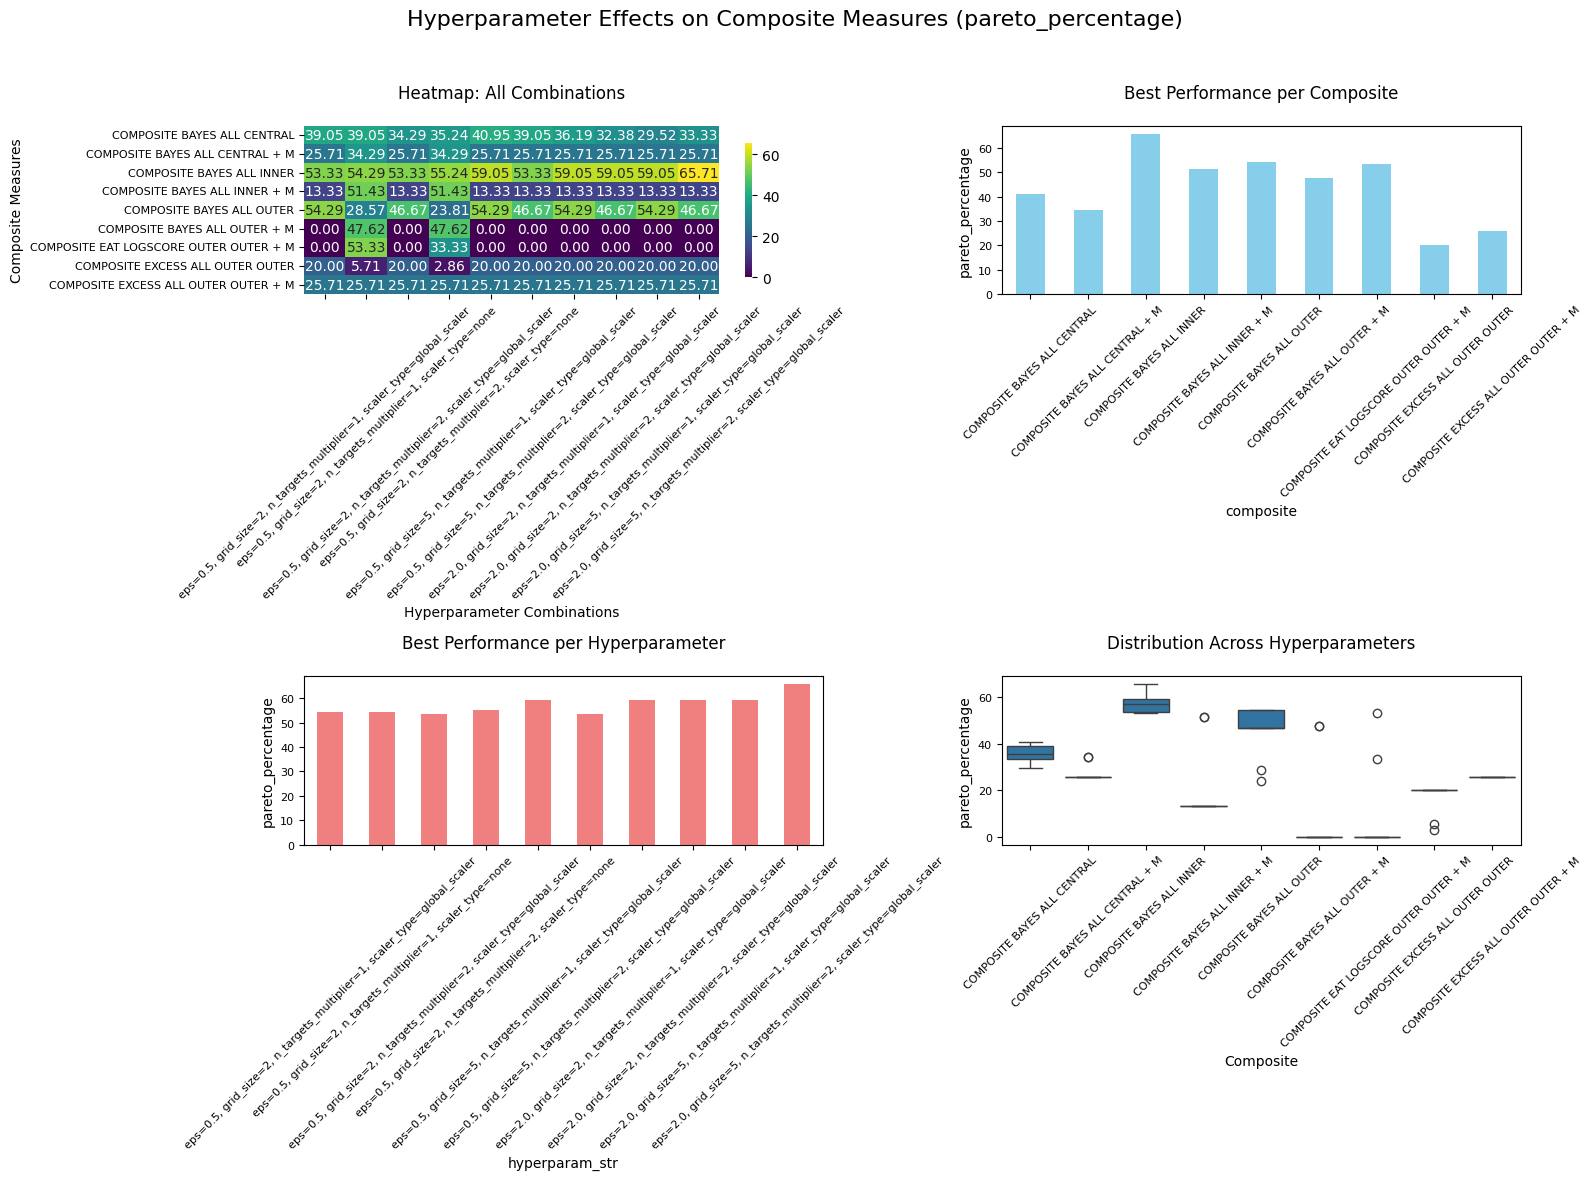

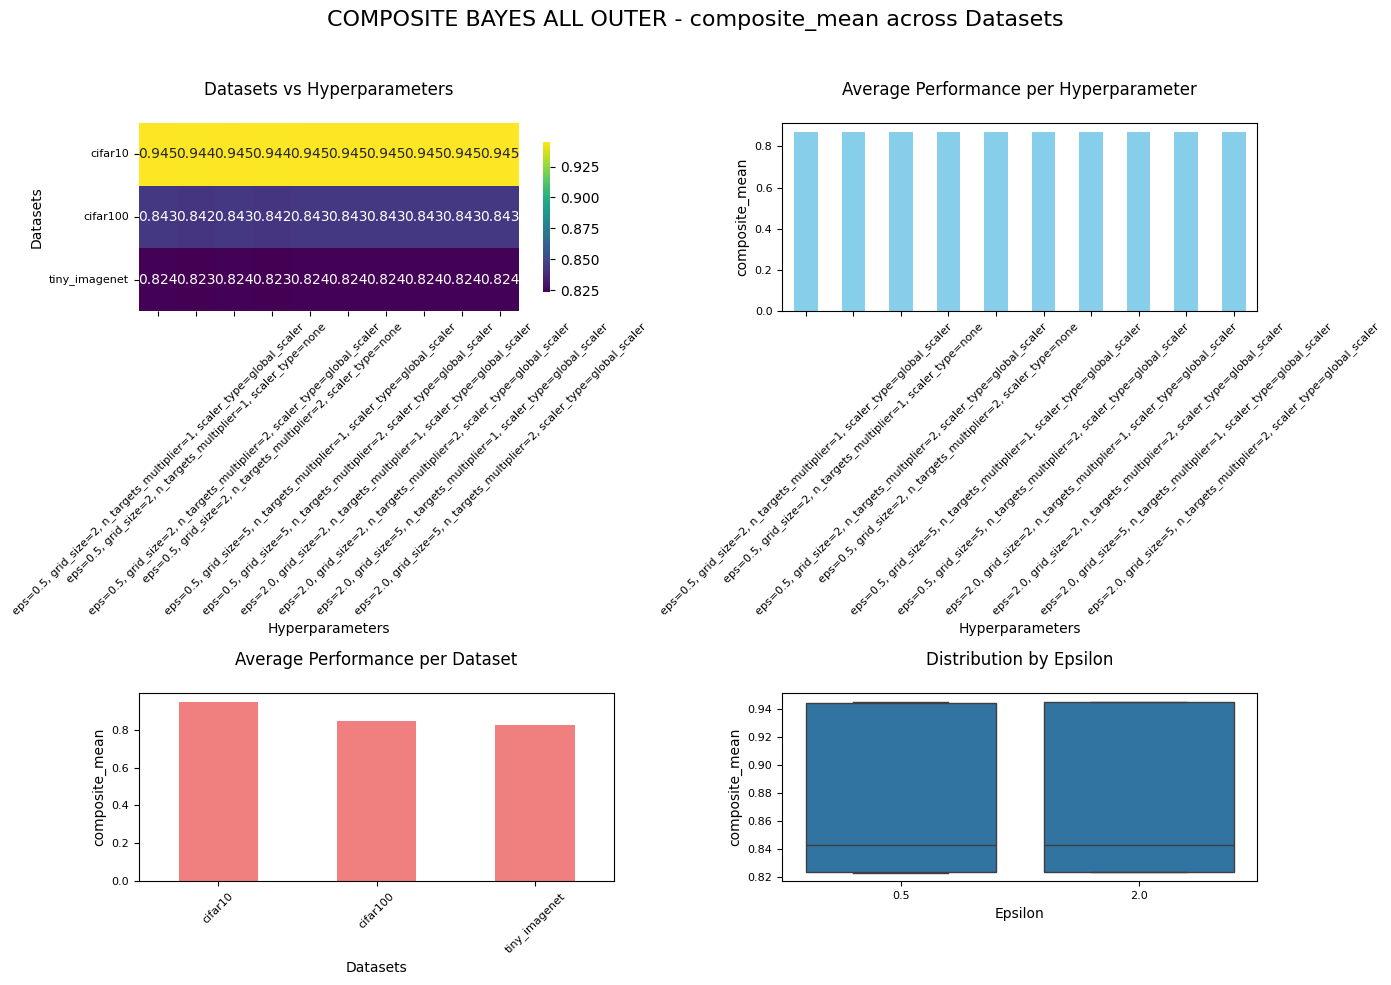

In [13]:
# Create visualizations
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Plot general hyperparameter effects
fig1 = plot_hyperparameter_effects(general_results, metric='pareto_percentage')
if fig1:
    plt.show()

# Plot per-dataset effects for a specific composite
if per_dataset_results:
    composite_to_plot = key_composites[0]  # "COMPOSITE BAYES ALL OUTER"
    fig2 = plot_per_dataset_effects(per_dataset_results, composite_to_plot, metric='composite_mean')
    if fig2:
        plt.show()


In [17]:
# Create comprehensive summary table
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE")
print("="*80)

summary_table = create_hyperparameter_summary_table(
    general_results, 
    metrics=['pareto_percentage', 'dominates_50_pct', 'dominates_75_pct', 'avg_rank']
)

# print(summary_table)

# Save results to CSV for further analysis
summary_table.to_csv('../hyperparameter_analysis_summary.csv', index=False)
print(f"\nSummary table saved to: ../hyperparameter_analysis_summary.csv")

display(summary_table)



COMPREHENSIVE SUMMARY TABLE

Summary table saved to: ../hyperparameter_analysis_summary.csv


,composite,hyperparams,eps,grid_size,n_targets_multiplier,scaler_type,pareto_percentage,dominates_50_pct,dominates_75_pct,avg_rank
0,COMPOSITE BAYES ALL OUTER,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",0.5,2,1,global_scaler,54.285714,11,9,23.400000
1,COMPOSITE BAYES ALL OUTER,"eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none",0.5,2,1,none,28.571429,10,6,25.666667
2,COMPOSITE BAYES ALL OUTER,"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",0.5,2,2,global_scaler,46.666667,11,8,23.200000
3,COMPOSITE BAYES ALL OUTER,"eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=none",0.5,2,2,none,23.809524,9,5,26.000000
4,COMPOSITE BAYES ALL OUTER,"eps=0.5, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",0.5,5,1,global_scaler,54.285714,11,9,23.400000
...,...,...,...,...,...,...,...,...,...,...
85,COMPOSITE EAT LOGSCORE OUTER OUTER + M,"eps=0.5, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler",0.5,5,2,global_scaler,0.000000,2,2,46.400000
86,COMPOSITE EAT LOGSCORE OUTER OUTER + M,"eps=2.0, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler",2.0,2,1,global_scaler,0.000000,2,2,46.400000
87,COMPOSITE EAT LOGSCORE OUTER OUTER + M,"eps=2.0, grid_size=2, n_targets_multiplier=2, scaler_type=global_scaler",2.0,2,2,global_scaler,0.000000,2,2,46.466667
88,COMPOSITE EAT LOGSCORE OUTER OUTER + M,"eps=2.0, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler",2.0,5,1,global_scaler,0.000000,2,2,46.333333


In [15]:
# Key insights and recommendations
print("\n" + "="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

print("HYPERPARAMETER ANALYSIS INSIGHTS:")
print("-" * 40)

if not summary_table.empty:
    # Analyze which hyperparameters perform best overall
    print("\n1. BEST HYPERPARAMETER COMBINATIONS:")
    
    # Group by hyperparameter combination and average metrics
    hyperparam_groups = summary_table.groupby('hyperparams').agg({
        'pareto_percentage': 'mean',
        'dominates_50_pct': 'mean', 
        'dominates_75_pct': 'mean'
    }).round(2)
    
    print("\nAverage performance by hyperparameter combination:")
    print(hyperparam_groups.sort_values('pareto_percentage', ascending=False))
    
    # Find best eps value
    if 'eps' in summary_table.columns:
        eps_performance = summary_table.groupby('eps')['pareto_percentage'].mean().sort_values(ascending=False)
        print(f"\n2. EPSILON (eps) ANALYSIS:")
        print(f"Best epsilon value: {eps_performance.index[0]} (avg Pareto %: {eps_performance.iloc[0]:.1f}%)")
        print("All epsilon values ranked:")
        for eps, perf in eps_performance.items():
            print(f"  eps={eps}: {perf:.1f}% avg Pareto performance")
    
    # Find best grid_size value
    if 'grid_size' in summary_table.columns:
        grid_performance = summary_table.groupby('grid_size')['pareto_percentage'].mean().sort_values(ascending=False)
        print(f"\n3. GRID SIZE ANALYSIS:")
        print(f"Best grid size: {grid_performance.index[0]} (avg Pareto %: {grid_performance.iloc[0]:.1f}%)")
        print("All grid sizes ranked:")
        for size, perf in grid_performance.items():
            print(f"  grid_size={size}: {perf:.1f}% avg Pareto performance")
    
    # Find best n_targets_multiplier value
    if 'n_targets_multiplier' in summary_table.columns:
        targets_performance = summary_table.groupby('n_targets_multiplier')['pareto_percentage'].mean().sort_values(ascending=False)
        print(f"\n4. N_TARGETS_MULTIPLIER ANALYSIS:")
        print(f"Best n_targets_multiplier: {targets_performance.index[0]} (avg Pareto %: {targets_performance.iloc[0]:.1f}%)")
        print("All n_targets_multiplier values ranked:")
        for mult, perf in targets_performance.items():
            print(f"  n_targets_multiplier={mult}: {perf:.1f}% avg Pareto performance")

print(f"\n5. OVERALL RECOMMENDATIONS:")
print("Based on this analysis:")
if not summary_table.empty:
    best_overall = hyperparam_groups.index[0]
    print(f"- Use hyperparameter combination: {best_overall}")
    print(f"- This achieves {hyperparam_groups.loc[best_overall, 'pareto_percentage']:.1f}% average Pareto performance")
    print(f"- And dominates 50% of components in {hyperparam_groups.loc[best_overall, 'dominates_50_pct']:.1f} cases on average")

print("\n6. NEXT STEPS:")
print("- Consider running additional experiments with intermediate parameter values")
print("- Test the best hyperparameter combination on held-out test data")
print("- Analyze computational cost vs performance trade-offs")
print("- Consider dataset-specific hyperparameter tuning for critical applications")



KEY INSIGHTS AND RECOMMENDATIONS
HYPERPARAMETER ANALYSIS INSIGHTS:
----------------------------------------

1. BEST HYPERPARAMETER COMBINATIONS:

Average performance by hyperparameter combination:
                                                                         pareto_percentage  \
hyperparams                                                                                  
eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=none                       37.78   
eps=0.5, grid_size=2, n_targets_multiplier=2, scaler_type=none                       34.39   
eps=0.5, grid_size=5, n_targets_multiplier=1, scaler_type=global_scaler              26.56   
eps=2.0, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler              26.03   
eps=0.5, grid_size=2, n_targets_multiplier=1, scaler_type=global_scaler              25.71   
eps=2.0, grid_size=5, n_targets_multiplier=2, scaler_type=global_scaler              25.61   
eps=2.0, grid_size=5, n_targets_multiplier=1, sca